In [3]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
from nitime import algorithms as alg
import warnings
warnings.filterwarnings("ignore")

In [4]:
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()
EDFfiles

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotations.txt', 'testing-montage-2.mtg', 'Tr

['s5d2_final.edf',
 's6n2_final.edf',
 'suj10_d1final.edf',
 'suj10_d2final.edf',
 'suj13_l2nap_day2 edited.edf',
 'suj13_l2nap_day2 edited1.edf',
 'suj5_d1final.edf',
 'suj6_d1final.edf',
 'suj8_d1final.edf',
 'suj8_d2final.edf',
 'suj9_d1final.edf',
 'suj9_d2final.edf']

In [5]:
file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=2)
# channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)# low pass
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])

Extracting edf Parameters from suj10_d1final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3601999  =      0.000 ...  3601.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    2, 7, 4, 4, 2
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Low-pass filtering at 5e+02 Hz
Low-pass filtering at 1e+02 Hz


In [6]:
ratio_index=[]
muscle_index=[]
sample_ind=[]
channelList=['F3','F4','C3','C4','O1','O2']

# Initialize
windowsize=5;
endPoint = 5;startPoint=endPoint-windowsize
distance_to_end = raw.last_samp/1000 - endPoint

while distance_to_end >5:
    for ii, names in enumerate(channelList):
        if ii == 0:
            start,stop = raw.time_as_index([startPoint,endPoint])
            tempSegment, time = raw[ii,start:stop]
            tempdata = tempSegment
            
        else:
            start,stop = raw.time_as_index([startPoint,endPoint])
            tempSegment, time = raw[ii,start:stop]
            tempdata += tempSegment
        
        filter_alpha = mne.filter.band_pass_filter(tempdata,1000,8,12.5);
        RMS_alpha = np.sqrt(sum(filter_alpha[0]**2)/len(filter_alpha))
        filter_spindle = mne.filter.band_pass_filter(tempdata,1000,11.5,16.5)
        RMS_spindle = np.sqrt(sum(filter_spindle[0]**2))/len(filter_spindle)
        filter_muscle = mne.filter.band_pass_filter(tempdata,1000,30,40.5)
        RMS_muscle = np.sqrt(sum(filter_muscle[0]**2)/len(filter_muscle))
        
        point = [0,0]
        if RMS_alpha/RMS_spindle < 1.2:
            point[0] +=2
            ratio_index.append(2)
        else:
            point[0] -= 1
            ratio_index.append(-1)
        if RMS_muscle >5*10e-4:
            point[1] -=1
            muscle_index.append(-1)
        else:
            point[1] += 1
            muscle_index.append(1)
        sample_ind.append(sum(point))
        
        endPoint += 0.5#determine step size, the smaller, the high sampling rate
        startPoint=endPoint-windowsize
        distance_to_end = raw.last_samp/1000 - endPoint 



In [10]:
print(sample_ind)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, -2, -2, -2, 0, 0, -2, -2, -2, -2, 0, 3, -2, -2, -2, -2, 0, 0, -2, -2, -2, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
general_result = pd.DataFrame(sample_ind)
mark_pairs=[]
indicator=[]
for ii in range(len(general_result)):
    if ii == len(general_result)-1:
        pass
    else:
        indicator.append(general_result[0][ii+1]-general_result[0][ii])
        #print(general_result[0][ii],indicator[ii],end=',')
        if indicator[ii] == -3:
            endPoint = ii * 0.5
            initial_position = ii;idx = ii
            try:
                while indicator[initial_position] != 3:
                    idx -= 1
                    initial_position = idx
                startPoint = idx * 0.5
                
                if endPoint - startPoint >= 1:
                    mark_pairs.append([startPoint,endPoint])
                    #print([startPoint,endPoint],end=' ')
            except:
                pass

In [12]:
mark_pairs = pd.DataFrame(mark_pairs)
print(mark_pairs)

          0       1
0     114.5   117.0
1     117.5   120.0
2     120.5   125.5
3     132.0   134.5
4     180.5   182.5
5     199.5   200.5
6     202.0   206.5
7     224.5   228.0
8     228.5   233.5
9     237.5   240.0
10    240.5   242.5
11    248.5   249.5
12    252.5   255.5
13    256.0   257.5
14    258.5   263.5
15    270.5   271.5
16    272.5   278.5
17    279.0   281.5
18    282.0   284.5
19    292.0   309.0
20    309.5   311.5
21    312.0   314.5
22    315.0   325.0
23    325.5   330.0
24    330.5   336.5
25    342.0   355.5
26    369.0   374.5
27    375.0   376.0
28    376.5   378.5
29    383.5   385.0
..      ...     ...
364  3371.5  3377.5
365  3379.0  3380.5
366  3381.0  3383.5
367  3384.0  3389.5
368  3392.5  3398.5
369  3399.0  3405.0
370  3405.5  3411.0
371  3411.5  3413.5
372  3418.0  3423.5
373  3424.0  3431.5
374  3439.0  3440.5
375  3442.0  3443.5
376  3453.0  3467.5
377  3477.0  3479.5
378  3480.0  3482.5
379  3483.0  3485.5
380  3490.0  3512.5
381  3520.0  3528.5


In [20]:
total_box=[];bag_box = []
for items in spindles:
    
    for rows in mark_pairs.iterrows():
        if (abs(rows[1][0]-items)<1) or (abs(rows[1][1]-items)<1):
            bag_box.append(1)
        
            
    #total_box.append(bag_box)
bag_box,spindles
sum(bag_box),len(spindles)

(82, 140)

In [24]:
sleep_annotation = []
searchLable = re.compile("Markon: 2",re.IGNORECASE)
for rows in file.iterrows():
    currentEvent = rows[-1][-1]
    if searchLable.search(currentEvent):
        sleep_annotation.append([rows[1][0],rows[1][0]+30])


In [31]:
len(sleep_annotation)

40

In [25]:
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))
getOverlap([0,10],[-1,11])

10

In [26]:
over_lapping_index=[]
for rows in mark_pairs.iterrows():
    #print(list(rows[1]))
    over_lapping=[]
    for items in sleep_annotation:
        over_lapping.append(getOverlap(list(rows[1]),items))
    #print(items)
    over_lapping_index.append(over_lapping)
    
over_lapping_index=np.array(over_lapping_index)
over_lapping_index[over_lapping_index<1.]=0

In [32]:
sum(bag_box),len(spindles),len(overlappingIndex)

(82, 140, 168)

In [27]:
overlappingIndex=[]
for idx, lines in enumerate(over_lapping_index):
    if sum((lines == 0).astype(int)-1) != 0:
        overlappingIndex.append(idx)
        
mark_pairs.loc[overlappingIndex]

,0,1
19,292.0,309.0
20,309.5,311.5
21,312.0,314.5
22,315.0,325.0
23,325.5,330.0
24,330.5,336.5
25,342.0,355.5
26,369.0,374.5
27,375.0,376.0
28,376.5,378.5


0    438
1    454
Name: 36, dtype: float64


(8, 20)

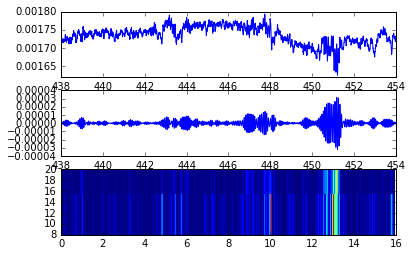

In [30]:
sample = mark_pairs.loc[36]
print(sample)
startPoint=sample[0];endPoint=sample[1]
start,stop = raw.time_as_index([startPoint,endPoint])
segment,time = raw[0,start:stop]
filter_segment = mne.filter.band_pass_filter(segment,1000,11.5,15.5)
plt.figure(1)
plt.subplot(311)
plt.plot(time,segment[0,:])
plt.subplot(312)
plt.plot(time,filter_segment[0,:])
plt.subplot(313)
f,t,Sxx = scipy.signal.spectrogram(segment[0,:],fs=1000,window=('hamming'),nperseg=128,noverlap=127)
plt.pcolormesh(t,f,Sxx)
plt.ylim([8,20])

In [13]:
#spindles